# Lichess Dataset Analysis

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the dataset
df = pd.read_csv('games.csv')

# Convert into datetime
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms') 
df['last_move_at'] = pd.to_datetime(df['last_move_at'], unit='ms') 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              20058 non-null  object        
 1   rated           20058 non-null  bool          
 2   created_at      20058 non-null  datetime64[ns]
 3   last_move_at    20058 non-null  datetime64[ns]
 4   turns           20058 non-null  int64         
 5   victory_status  20058 non-null  object        
 6   winner          20058 non-null  object        
 7   increment_code  20058 non-null  object        
 8   white_id        20058 non-null  object        
 9   white_rating    20058 non-null  int64         
 10  black_id        20058 non-null  object        
 11  black_rating    20058 non-null  int64         
 12  moves           20058 non-null  object        
 13  opening_eco     20058 non-null  object        
 14  opening_name    20058 non-null  object        
 15  op

# Exploratory Data Analysis

## Class Imbalance

In [3]:
print('Percentage of Winners in the game')
class_imb = round(df['winner'].value_counts(normalize=True)*100, 2)
for ind in class_imb.index:
    print(f'{ind.capitalize()} = {class_imb[ind]} %')

print('\nNumber of Draw games = ', df['winner'].value_counts()['draw'])

Percentage of Winners in the game
White = 49.86 %
Black = 45.4 %
Draw = 4.74 %

Number of Draw games =  950


As `White` win and `Black` win percentages are close to each other, we can say that there is no class imbalance here. The `Draw` percentage is very small but the number of games is significant amount, so we will make observations in this as well

## Nature of Victory

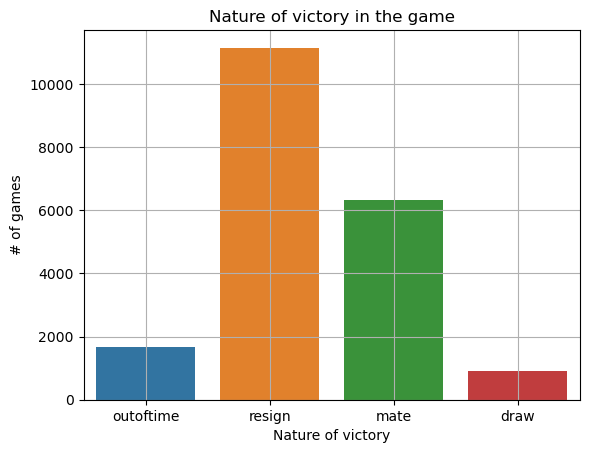

In [4]:
sns.countplot(data=df, x='victory_status')
plt.title('Nature of victory in the game')
plt.xlabel('Nature of victory')
plt.ylabel('# of games')
plt.grid(True)
plt.show()

It can be observed that players tend to resign than to continue until the end

### Is it the same in all formats of games

In [5]:
# Split increment_code:
df['base_time'] = df['increment_code'].str.split('+').str[0].astype(int)
df['increment_time'] = df['increment_code'].str.split('+').str[1].astype(int)
df.drop(columns='increment_code', inplace=True)

# categorize the games
conditions = [
    (df['base_time'] < 3),
    (df['base_time'] >= 3) & (df['base_time'] < 10),
    (df['base_time'] >= 10) & (df['base_time'] < 30),
    (df['base_time'] >= 30)
]

choices = ['Bullet', 'Blitz', 'Rapid', 'Classical']

df['format'] = np.select(conditions, choices, default='Unknown')

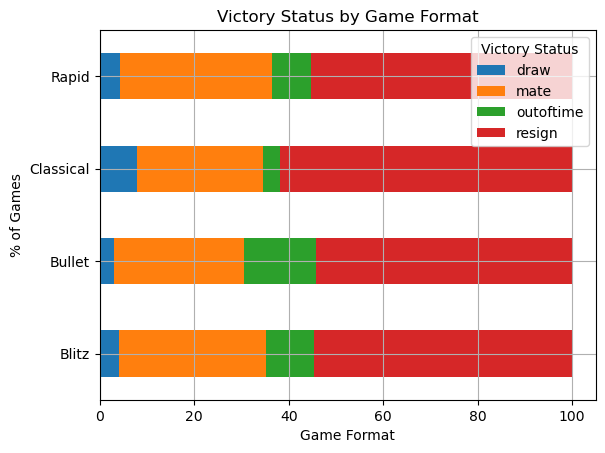

In [6]:
# Add a column for counting 
df['count'] = 1

# Pivot the DataFrame and calculate percentages
pivot_df = df.pivot_table(index='format', columns='victory_status', values='count', aggfunc='sum', fill_value=0)
pivot_df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart
pivot_df_percentage.plot(kind='barh', stacked=True)

plt.title('Victory Status by Game Format')
plt.xlabel('Game Format')
plt.ylabel('% of Games')
plt.legend(title='Victory Status')
plt.grid(True)
plt.show()


Same behaviour can be observed in different formats of the game as well. A few observations are:
1. Players tend to draw more in Clasical format of the game
1. Classical format of the game has more time, so ending a match by running out of time is lesser
1. Players calulate a few moves ahead in classical format of the game, so the percentage of resignations is more here
1. Bullet is a faster format and so running out of time is more probable here than other games

## Rated vs Non-Rated

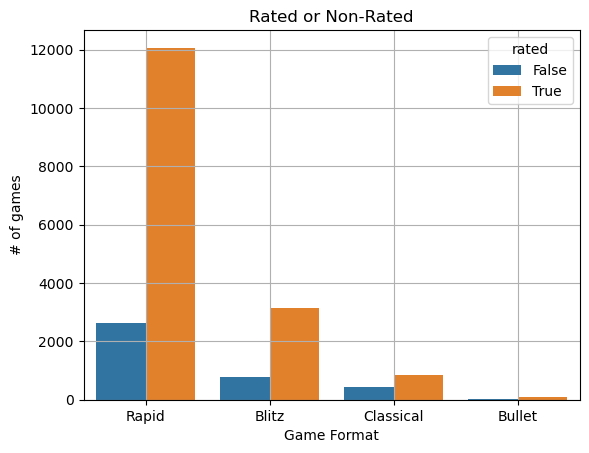

In [7]:
sns.countplot(data=df, x='format', hue='rated')
plt.title('Rated or Non-Rated')
plt.xlabel('Game Format')
plt.ylabel('# of games')
plt.grid(True)
plt.show()

In any format of the game, players prefer Rated games (where the outcome of the game effects their rating) indicating this is a serious platform

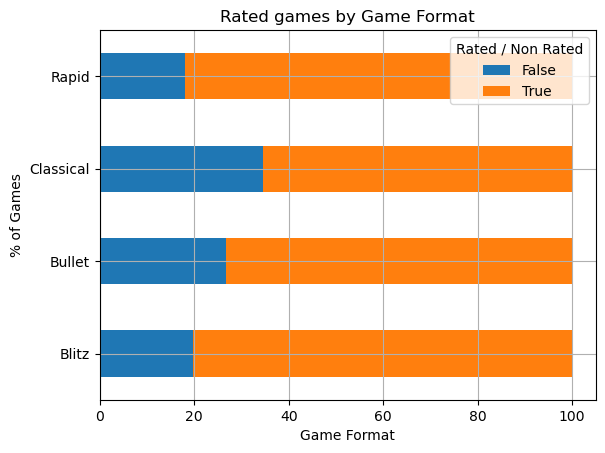

In [8]:
# Pivot the DataFrame and calculate percentages
pivot_df = df.pivot_table(index='format', columns='rated', values='count', aggfunc='sum', fill_value=0)
pivot_df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart
pivot_df_percentage.plot(kind='barh', stacked=True)

plt.title('Rated games by Game Format')
plt.xlabel('Game Format')
plt.ylabel('% of Games')
plt.legend(title='Rated / Non Rated')
plt.grid(True)
plt.show()

Players tend to not prefer Rated match in the classical format of the game

## Beat the odds

In [9]:
condition = (((df['winner'] == 'white') & (df['white_rating'] < df['black_rating'])) | ((df['winner'] == 'black') & (df['black_rating'] < df['white_rating'])))
df['beat_the_odds'] = np.where(condition, 1, 0)

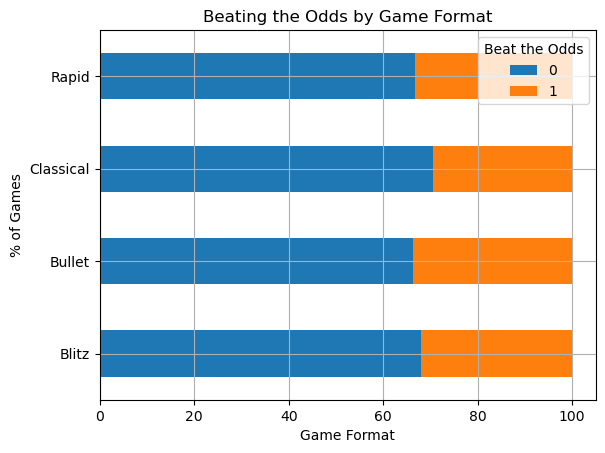

In [10]:
# Pivot the DataFrame and calculate percentages
pivot_df = df.pivot_table(index='format', columns='beat_the_odds', values='count', aggfunc='sum', fill_value=0)
pivot_df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart
pivot_df_percentage.plot(kind='barh', stacked=True)

plt.title('Beating the Odds by Game Format')
plt.xlabel('Game Format')
plt.ylabel('% of Games')
plt.legend(title='Beat the Odds')
plt.grid(True)
plt.show()

There is not a lot of variation as per format of the game. On an average, 30% chances for a low rated player to beat a higher rated player

In [11]:
df['rating_difference'] = df['white_rating'] - df['black_rating']

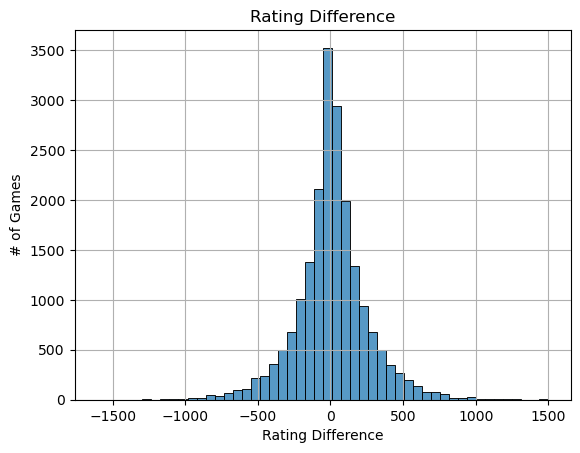

In [12]:
sns.histplot(data=df, x='rating_difference', bins=50)
plt.title('Rating Difference')
plt.xlabel('Rating Difference')
plt.ylabel('# of Games')
plt.grid(True)
plt.show()

This histogram shows that as high as a difference of 500 rating points exists in a few matches

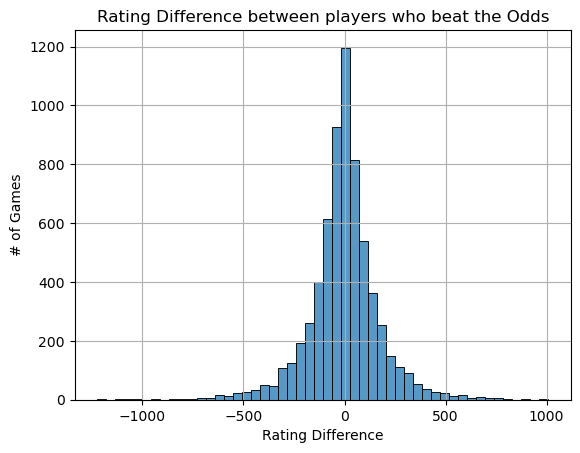

In [13]:
sns.histplot(data=df[df['beat_the_odds'] == 1], x='rating_difference', bins=50)
plt.title('Rating Difference between players who beat the Odds')
plt.xlabel('Rating Difference')
plt.ylabel('# of Games')
plt.grid(True)
plt.show()

In the histogram where we took the data of only the matches where a low rated player beat the high rated player, we can see that sometimes rating difference of >400 exists. This can be possible when:
1. lower rated player was climibing the ladder and met a higher rated player but who was inferior than the lower rated players' true potential
1. higher rated player committing blunders
1. un-natural reasons like weaker internet connection, playing through different account etc..

## Turns in a game

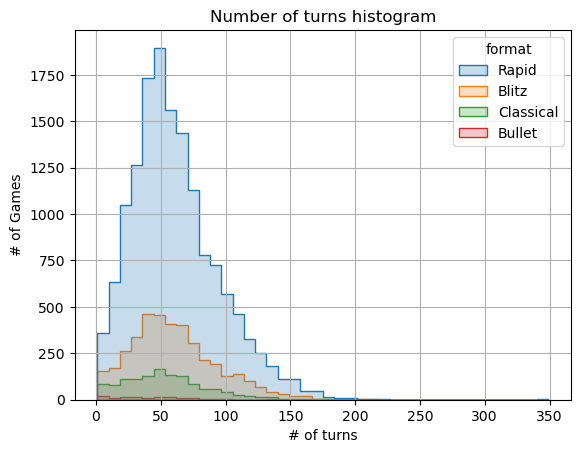

In [26]:
sns.histplot(data=df, x='turns', hue='format', element='step', bins=40)
plt.title('Number of turns histogram')
plt.xlabel('# of turns')
plt.ylabel('# of Games')
plt.grid(True)
plt.show()

In all formats of the games and in the overal data too, we can observe that a game lasts for around 50 moves.

## Choice of player

<Axes: xlabel='white_rating', ylabel='black_rating'>

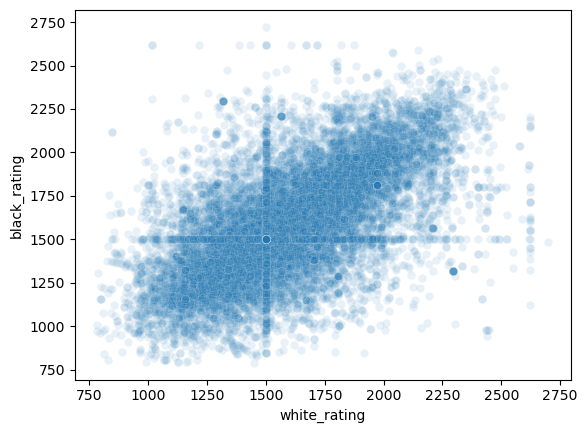

In [15]:
sns.scatterplot(data=df, x='white_rating', y='black_rating', alpha=0.1)

Games are generally between similar rated players as can be seen from the linear pattern, but there are also games where the difference in rating is large

## The unusual straight line

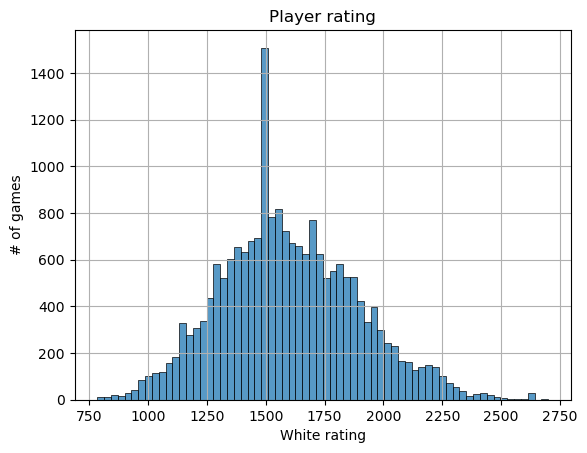

In [16]:
sns.histplot(data=df, x='white_rating')
plt.title('Player rating')
plt.xlabel('White rating')
plt.ylabel('# of games')
plt.grid(True)
plt.show()

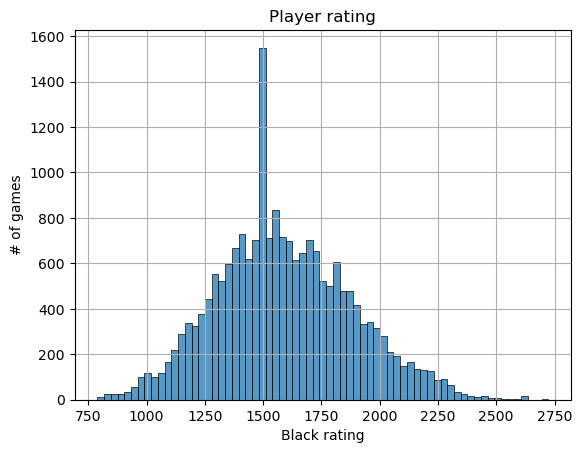

In [17]:
sns.histplot(data=df, x='black_rating')
plt.title('Player rating')
plt.xlabel('Black rating')
plt.ylabel('# of games')
plt.grid(True)
plt.show()

The graphs follow normal distribution which is expected. But the sudden spike at 1500 indicates that there are a lot of players with exactly that rating which is unusual. A new player is assigned the rating of 1500. Hence it can be concluded that there are a lot of new account creations in this platform

## Playing by the Book

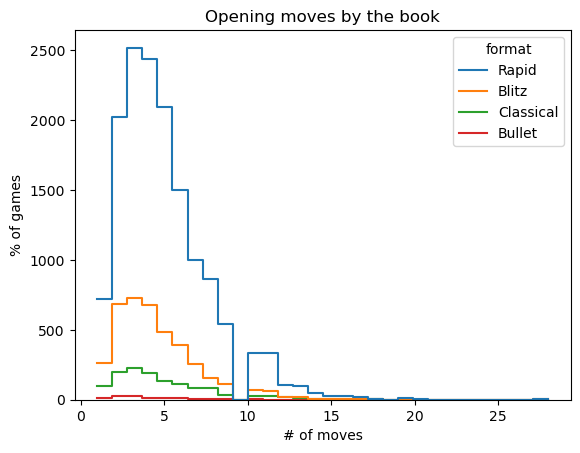

In [62]:
sns.histplot(data=df, x='opening_ply',fill=False, element='step', hue='format', bins=30)
plt.title('Opening moves by the book')
plt.xlabel('# of moves')
plt.ylabel('% of games')
# plt.grid(True)
plt.show()

Histogram indicates that players play 3-4 moves by the book

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 20058 non-null  object        
 1   rated              20058 non-null  bool          
 2   created_at         20058 non-null  datetime64[ns]
 3   last_move_at       20058 non-null  datetime64[ns]
 4   turns              20058 non-null  int64         
 5   victory_status     20058 non-null  object        
 6   winner             20058 non-null  object        
 7   white_id           20058 non-null  object        
 8   white_rating       20058 non-null  int64         
 9   black_id           20058 non-null  object        
 10  black_rating       20058 non-null  int64         
 11  moves              20058 non-null  object        
 12  opening_eco        20058 non-null  object        
 13  opening_name       20058 non-null  object        
 14  openin

## Opening choice

In [72]:
print('Unique Opening names in this dataset: ', len(df['opening_name'].unique()))
print('Unique opening ECO names in this dataset: ', len(df['opening_eco'].unique()))

Unique Opening names in this dataset:  1477
Unique Eco names in this dataset:  365


Opening name and opening Eco name convey the same meaning. ECO names are more standardised way of denoting the popular openings in chess. In this case, since ECO names are less diverse, it will give a broader picture and hence it shall be used to continue the analysis